### Import packages and functions

All of the functions and models used in this workbook are in the packages and functions imported below.

In [22]:
import numpy as np
import pandas as pd
from sklearn import tree, ensemble
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score, 
    ConfusionMatrixDisplay
)
from sklearn.model_selection import cross_validate

### Import dataset

The dataset is as described in the datasheet. It is Credit Card Fraud data uploaded to Kaggle by the Machine Learning Group - ULB and was originally collected and analysed as part of a research collaboration of Worldline and the Machine Learning Group.

The data can be downloaded here: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

The website also gives a full list of acknowledgements regarding the data.

I have saved it as a csv in the local directory where this notebook was run.

The data is from credit card transactions. The Time variable is the number of seconds since the first transaction, and the Amount variable is the monetary value of the transaction. The Class variable indicates if a transaction is fraud (value 1) or not fraud (value 0). The other variables, labelled V1 - V28 are anonymised characteristics of the collected data, and represent the most important features following a PCA transformation.

Because the features have been anonymised and transformed, this could also be used as a proxy for other financial ledgers where fraud detection is important, for example a company's sales ledger during a fraud investigation or financial audit. However, this should be done with caution and only to generate ideas, and any models taken forward to testing on data more relevant to that use case.



In [2]:
df=pd.read_csv('creditcard.csv')
df.sort_values(by=["Time"], inplace=True)
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,...,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


As would be expected (or at least hoped for!), the data is highly unbalanced, with 492 fraudulant transactions out of 284,807 transactions.

In [12]:
print("Number of transactions:", len(df))
print("Number of fraudulant transactions:", sum(df["Class"]))

Number of transactions: 284807
Number of fraudulant transactions: 492


There are no rows containing missing data, as the data has already undergone pre-processing and transformation.

In [17]:
df1 = df[df.isna().any(axis=1)]
df1

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class


### Set size of training and validation data (combined as cross validation is used) and test data

75% of the data is used for training (included 5-fold cross validation), and the remaining 25% is held as an independent test set.

In [13]:
print("Total records:", len(df))
trainsize = int(len(df) * 0.75)
print("Size of training and validation data:", trainsize)
testsize=len(df)-trainsize
print("Size of test data:", testsize)

Total records: 284807
Size of training and validation data: 213605
Size of test data: 71202


The test data is the final 25% of the data. The reason for this choice is that fraud detection models are  trained on historic data and then used to identify fraud in live transactions (or at least more recent transactions). Therefore this split of test and training data most accurately reflects the real use case for such models.

In [14]:
train_and_val_df = df.head(trainsize)
len(train_and_val_df)
test_df = df.tail(testsize)
print(len(train_and_val_df))
print(len(test_df))

213605
71202


The training and test data are converted to numpy arrays for use in the models, the outcome variables are split into "y" and "y_test", and the "Time" variable is dropped. The "Time" variable is measured in seconds after the first transaction and therefore should not be used to train the model, as it is not a characteristic of the transaction itself, but a measure of age relative to the other data.

In [8]:
Xy=np.array(train_and_val_df.drop(["Time"], axis=1))
seed = np.random.seed(1)
np.random.shuffle(Xy)
X=Xy[:,:-1]
y=Xy[:,-1]

Xy_test = np.array(test_df.drop(["Time"], axis=1))
X_test = Xy_test[:,:-1]
y_test = Xy_test[:,-1]

### Choice of Model

#### Type of problem

The problem being addressed is the classification of transactions as fraudulant or not fraudulant. It is a classification problem with two classes: 1 for fraud; and 0 for not fraud.


#### Choice of model

Although the data is from credit card transactions, as the variables and transactions are fully anonymised and transformed, I am also considering how machine learning could be used in other contexts. For example, V1 to V28 could also represent the characteristics of transactions in a company's financial ledger. Although the data was not collected for this purpose, the principle is the same. 

Therefore, I am choosing to use a decision tree model to classify the transactions. The key reason for this is interpretability and explainability. In detecting financial fraud, there is often a high level of documentation and need for review, for example as part of a forensic investigation to report to a Board (or even end up in court) or as part of the search for fraudulent transactions during a financial audit. Therefore, being able to justify the selection of transactions for investigation is crucial. This would also be true for credit card fraud detection, where it would be needed to explain to customers why transactions were being blocked or investigated, and it would need to be understood why some fraudulent transactions were not identified.

There are a wide variety of classification models which could have been used, including the below:
1. Support vector machines: these can provide a powerful classifier, but they would not be explainable to the end user.
2. K-nearest neighbour: As there are 28 variables, the distance metric would be connecting transactions which may in reality not be that close. Furthermore, it may not be suitable for this particular problem as it would be possible for many fraudulent transactions to have more non-fraudulent neighbours due to the significant imbalance. 
3. Neural network: this could be a powerful alternative, but would need to have interpretability built in to it. As a follow up project to this, it would be interesting to train a neural network, using a decision tree approximation of the resulting network to be able to understand the decisions made when classifyibng new data.

### Hyperparameter tuning

#### Hyperparameters:

There are two key challenges to this dataset and choice of model:

1. Decision trees often overfit to the training data and therefore do not generalise well without applying sensible hyperparameters.

2. The data is highly unbalanced with only 492 out of 284,807 transactions being fraudulant. Therefore accuracy alone is not a suitable measure as a simple classifier which classifiers everything as "not fraud" would have an accuracy of 99.8%.

The hyperparameters that will be tuned to address the two problems are:

1. Max depth of the decision tree. If the tree goes to too great a depth, it will overfit. However, by capping the depth it will avoid this concern. It will also play into one of the biggest strengths of Decision Trees, which is their interpretability and explainability.

2. The class weights applied to th fraud ("1") and not fraud ("0") classes. Because the dataset is so unbalanced, placing greater weight on the fraud instances when deciding how to split a node will result in higher sensitivity by placing greater emphasis on the fraud instances.



#### Metrics for tuning:

In fraud detection, the cost of not identifying a fraud (in money lost including potential fines, time investigating, and reputation) is significantly greater than the cost (in time, resourcing, and customer reputation). Therefore, it is important to have a high recall, also known as sensitivity (fraud is the positive classification with a value of 1). 

Therefore, for each combination of hyperparameters, we will obtain the following scoring metrics:
1. Accuracy
2. Precision
3. Recall
4. F1 Score

We shall choose the best model on the basis of two criteria:
1. The highest F1 score, as this metric balances Recall with Precision for the unbalanced classes.
2. The highest recall, but only considering models where Precision is above a fixed minimum. In this example I will use 80%, but this could be adjusted up or down in line with the users risk appetite. A lower threshold will give more weight to recall (i.e. identifying true positives), whereas a higher threshold will have a potentially worse recall, but reduce the investigation costs of false positives.

#### Approach to tuning

The max depth is a discrete variable, and as the key reason for choosing a decision tree was interpretability, the maximum max depth we will investigate is 10, as beyond this the model can become unduly complicated.

The weights can be any value and are continuous. However, as we are representing the relative weights of two classes, this can be simplified to a weight of W for the 0 class and (1-W) for the 1 class. Furthermore, as the 0 class has many more entries than the 1 class, we will not look at W with value above 0.5 (as otherwise it will worsen rather than improve the imbalance).

Although W is a continuous variable, we will use a grid search at intervals of 0.1, along with building a model with "balanced" weights, where the class imbalance is totally corrected to a 50/50 split. Splitting the weights into intervals beyond 0.1 (plus balanced weights) would potentially not generalise well and may lead to fitting weights which score well on the cross validation, but not on general datasets. However, it would be another follow up of interest to tune a Bayesian optimisation model which selects the optimal weight to maximise each of the two metrics described above. This is not performed in this project due to time constraints, but would be of interest to the author.

#### Cross validation approach

As there is a high risk of overfitting, and we do not want to select a model which performs well on a validation set but not more generally, k-fold cross validation was selected.

5-folds were chosen for two reasons:
1. This should still contain a reasonably high number of frauds (relative to total frauds) in each fold - beyond 5 and there is a risk of some folds having close to nil frauds.
2. Time taken to run through the grid search - with 5 folds, the time taken is efficient to run the experiment compared to, for example a 10-fold cross validation approach.

#### Code to build and cross validate each model to tune hyperparameters

In [16]:
# Build empty lists to hold the final results (including full cross validation dictionaries)

results=[]
cv_dicts_list=[]


# Calculate the balanced weights and scale to the 0-1 used for the 0.1-0.5 range of weights as described above.

weight_vals = np.arange(0.1, 0.6, 0.1)
balanced_weights = class_weight.compute_class_weight(class_weight='balanced', classes=[0,1], y=y)
balanced_weights = balanced_weights/sum(balanced_weights)

weight_vals = np.append(weight_vals, balanced_weights[0])

print(weight_vals)

# Set maximum value for max depth to cycle to.

max_depth = 10


# Build a model for every combination of max depth from 1 to 10 and weights in the set:
# [Balanced, 0.1, 0.2, 0.3, 0.4, 0.5]

for i in range(max_depth):
    print("max depth:", i+1) # Print statement to record progress
    
    for j in range(len(weight_vals)):
        
        # Set weights 
        weights={0: np.round(weight_vals[j],6),
                 1: np.round(1-weight_vals[j],6)}
        print("weights", weights) # Print statement to record progress
        
        # Set model with chosen hyperparameters
        clf = tree.DecisionTreeClassifier(max_depth=i+1, random_state=1, class_weight=weights)
        
        # Cross-validate and record performance metrics.
        cv_dict = cross_validate(clf, X, y, scoring=['accuracy', 'recall', 'precision','f1_macro'])
        f1 = np.mean(cv_dict.get('test_f1_macro'))
        acc = np.mean(cv_dict.get('test_accuracy'))
        rec = np.mean(cv_dict.get('test_recall'))
        prec = np.mean(cv_dict.get('test_precision'))
        result=[i+1, weights.get(0), acc, prec, rec, f1]
        
        print(result) # Print statement to record progress
        
        # Store results
        results.append(result)
        cv_dicts_list.append(cv_dict)

[0.1        0.2        0.3        0.4        0.5        0.00186325]
max depth: 1
weights {0: 0.1, 1: 0.9}
[1, 0.1, 0.9989045200252804, 0.69921165225112, 0.7361708860759493, 0.8574192988093408]
weights {0: 0.2, 1: 0.8}
[1, 0.2, 0.9990543292525924, 0.7525542001857791, 0.733639240506329, 0.8712203571727386]
weights {0: 0.3, 1: 0.7}
[1, 0.3, 0.999068373867653, 0.7596420452742905, 0.7311392405063291, 0.8722944071673158]
weights {0: 0.4, 1: 0.6}
[1, 0.4, 0.9990636923292995, 0.7615693988695462, 0.7235443037974683, 0.8707018398305626]
weights {0: 0.5, 1: 0.5}
[1, 0.5, 0.9990636923292995, 0.7615693988695462, 0.7235443037974683, 0.8707018398305626]
weights {0: 0.001863, 1: 0.998137}
[1, 0.001863, 0.9768544743802814, 0.0660729679510184, 0.8691772151898733, 0.5555371914668628]
max depth: 2
weights {0: 0.1, 1: 0.9}
[2, 0.1, 0.9986049015706561, 0.5879099694733573, 0.8415189873417722, 0.8455968363524795]
weights {0: 0.2, 1: 0.8}
[2, 0.2, 0.9989887877156434, 0.7239285344969792, 0.7637974683544304, 0.8

#### Selection of hyper-parameters

The results are converted to a labelled dataframe for clarity.

From this, they can be sorted by F1 score to identify those performing best under the first criterion, and then sorted by recall and filtered on precision to identify the parameters performing best under the second criterion.

In [18]:
df_results = pd.DataFrame(results, columns = ['Max_Depth', 'Weight_on_0', 'Accuracy', 'Precision', 'Recall', 'f1_score'])

Highest performing models based on F1 score:

In [19]:
df_results.sort_values(by=["f1_score"], inplace=True, ascending=False)
df_results.head(10)

,Max_Depth,Weight_on_0,Accuracy,Precision,Recall,f1_score
32,6,0.3,0.999494,0.916115,0.803797,0.927192
26,5,0.3,0.999471,0.905945,0.801297,0.924221
27,5,0.4,0.999466,0.901216,0.803734,0.923526
38,7,0.3,0.999466,0.902235,0.801266,0.923521
39,7,0.4,0.999462,0.906409,0.793608,0.921766
33,6,0.4,0.999462,0.909407,0.791076,0.921415
31,6,0.2,0.999438,0.882737,0.806392,0.921087
44,8,0.3,0.999443,0.896910,0.793734,0.920028
40,7,0.5,0.999443,0.898380,0.791108,0.919485
34,6,0.5,0.999443,0.903453,0.786076,0.918864


Highest performing models based on recall, with a minimum precision of 80%:

In [20]:
df_results.sort_values(by=["Recall"], inplace=True, ascending=False)
df_results_prec_over_80 = df_results.loc[df_results["Precision"]>=0.8]
df_results_prec_over_80.head(10)

,Max_Depth,Weight_on_0,Accuracy,Precision,Recall,f1_score
19,4,0.2,0.999359,0.825339,0.831456,0.913839
18,4,0.1,0.999335,0.817219,0.828987,0.911121
20,4,0.3,0.999359,0.837357,0.813924,0.912133
25,5,0.2,0.999368,0.846837,0.811392,0.913508
31,6,0.2,0.999438,0.882737,0.806392,0.921087
42,8,0.1,0.999321,0.830470,0.806361,0.907856
32,6,0.3,0.999494,0.916115,0.803797,0.927192
27,5,0.4,0.999466,0.901216,0.803734,0.923526
48,9,0.1,0.999302,0.825125,0.801361,0.905132
26,5,0.3,0.999471,0.905945,0.801297,0.924221


### Testing performance

Now we have tuned the hyper-parameters to select the models which perform best under each of the two criteria we set, we can test their performance on the 25% of the data held back for testing.

#### Criterion 1 - best F1 score:

Accuracy of model: 0.9994663071262043
Precision of model: 0.9242424242424242
Recall of model: 0.648936170212766
F1 Score of model: 0.7625000000000001


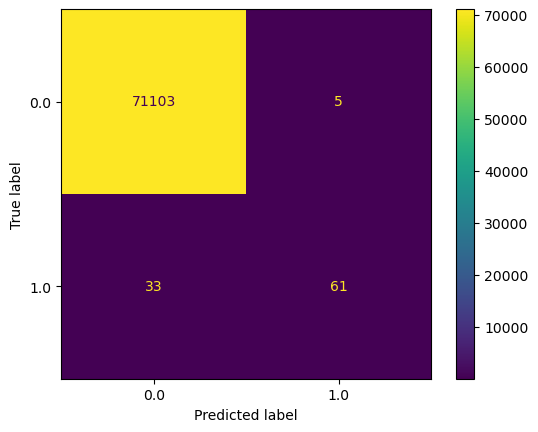

In [23]:
weights={0:0.3, 1: 0.7}
clf = tree.DecisionTreeClassifier(max_depth=6, random_state=1, class_weight=weights)
clf.fit(X,y)

acc = accuracy_score(y_test, clf.predict(X_test))
prec = precision_score(y_test, clf.predict(X_test))
rec = recall_score(y_test, clf.predict(X_test))
f1 = f1_score(y_test, clf.predict(X_test))

print("Accuracy of model:", acc)
print("Precision of model:", prec)
print("Recall of model:", rec)
print("F1 Score of model:", f1)

cm = confusion_matrix(y_test, clf.predict(X_test))
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cmd.plot()

#### Criterion 2 - best recall (with precision greater than 80%in cross validation):

Accuracy of model: 0.999522485323446
Precision of model: 0.8846153846153846
Recall of model: 0.7340425531914894
F1 Score of model: 0.8023255813953488


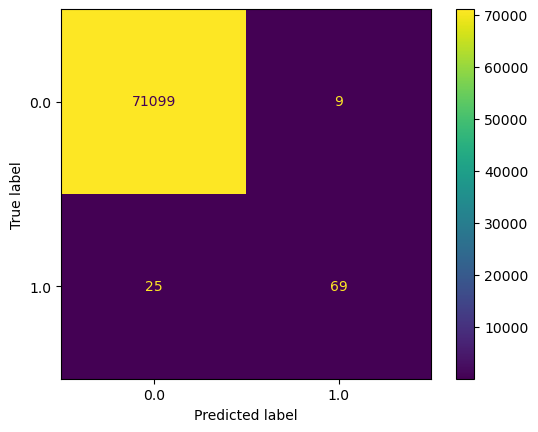

In [25]:
weights={0:0.2, 1: 0.8}
clf = tree.DecisionTreeClassifier(max_depth=4, random_state=1, class_weight=weights)
clf.fit(X,y)

acc = accuracy_score(y_test, clf.predict(X_test))
prec = precision_score(y_test, clf.predict(X_test))
rec = recall_score(y_test, clf.predict(X_test))
f1 = f1_score(y_test, clf.predict(X_test))

print("Accuracy of model:", acc)
print("Precision of model:", prec)
print("Recall of model:", rec)
print("F1 Score of model:", f1)

cm = confusion_matrix(y_test, clf.predict(X_test))
cmd = ConfusionMatrixDisplay(cm, display_labels=np.unique(y))
cmd.plot()

Given that false negatives are potentially much more costly than false positives, the second model overall appears to have the best generalised performance. Furthermore, depending on the risk appetite of the user, it may be worth reducing the minimum precision still further to increase the recall on new data.